In [1]:
__author__ = 'Vaibhav Kumar'

from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
import cv2

from PIL import Image
from torch.nn.functional import interpolate

import numpy as np
from numpy import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F

plt.ion()

https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/ 
https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html

In [29]:
# Dataset Class
class PNGDataset(Dataset):
    """png dataset"""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
      list = os.listdir(self.root_dir)
      count=len(list)
      print(count)
      return count  

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # list of all files in directory
        dir = os.listdir(self.root_dir)
        # for item in dir:
        #   print(item)
        img_name = os.path.join(self.root_dir,dir[idx])
        image = io.imread(img_name)            
        sample = {'image': image}

        if self.transform:
            sample = self.transform(sample)

        return sample

    # def __getitem__(self, idx):
    #     if torch.is_tensor(idx):
    #         idx = idx.tolist()

    #     img_name = os.path.join(self.root_dir,str(idx)+".png")
    #     image = io.imread(img_name)            
    #     sample = {'image': image}

    #     if self.transform:
    #         sample = self.transform(sample)

    #     return sample

In [21]:
def expand2square(pil_img, background_color):
  width, height = pil_img.size
  if width == height:
      return pil_img
  elif width > height:
      result = Image.new(pil_img.mode, (width, width), background_color)
      result.paste(pil_img, (0, (width - height) // 2))
      return result
  else:
      result = Image.new(pil_img.mode, (height, height), background_color)
      result.paste(pil_img, ((height - width) // 2, 0))
      return result

In [22]:
def check_dir_exist(path):
  if os.path.isdir(path):
    print("Exists")
  else:
    print("Doesn't exists")
    os.mkdir(path)

https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python 
https://stackoverflow.com/questions/3211595/renaming-files-in-a-folder-to-sequential-numbers
https://stackoverflow.com/questions/82831/how-do-i-check-whether-a-file-exists-without-exceptions 

In [8]:
# process 2D characters first then frontview of rignet characters (all png files)
# the naming convention for them is different
def process_png_dataset(processing_obj, dataset, rootpath, newpath):
  iterations = 0
  while (iterations <= len(dataset)-1):
    if (processing_obj != True):
      for i in range (len(dataset)-1):
          fname = rootpath+"/"+str(i)+'.png'
          if (os.path.isfile(fname)==True):
            im = Image.open(fname)
            # Padding 
            im_new = expand2square(im, (255, 255, 255))
            # Convert to grayscale
            im_new = im_new.convert('LA')
            im_new.save(newpath+str(i)+'.png', quality=95)
            iterations+=1
          else:
            processing_obj = True
            break
    else:        
        for i in range (len(dataset)-1):
          fname = rootpath+"/obj"+str(i)+'.png'
          if (os.path.isfile(fname)==True):
            im = Image.open(fname)
            # Padding 
            im_new = expand2square(im, (0, 0, 0))
            # Convert to grayscale
            im_new = im_new.convert('LA')
            # CHANGE THE NAMING HERE!!!!!!!!!!!
            im_new.save(newpath+"/obj"+str(i)+'.png', quality=95)
            iterations+=1
          else:
            break

In [9]:
def process_png_dataset_test(dataset,rootpath,newpath):
  for i in range (len(dataset)-1):
    im = Image.open(rootpath+str(i)+'.png')
    # Padding 
    im_new = expand2square(im, (255, 255, 255))
    # Convert to grayscale
    im_new = im_new.convert('LA')
    im_new.save(newpath+str(i)+'.png', quality=95)

# def process_obj_dataset(dataset,rootpath,newpath):
#   for i in range (len(dataset)-1):
#     im = Image.open(rootpath+"/obj"+str(i)+'.png')
#     # Padding 
#     im_new = expand2square(im, (0, 0, 0))
#     # Convert to grayscale
#     im_new = im_new.convert('LA')
#     im_new.save(newpath+str(i)+'.png', quality=95)

In [23]:
# Initialize datasets
# png_dataset = PNGDataset(root_dir='/content/drive/MyDrive/png_files')
png_dataset = PNGDataset(root_dir='/content/drive/MyDrive/2D_and_rignet')
png_dataset_test = PNGDataset(root_dir='/content/drive/MyDrive/png_files_test')

In [30]:
check_dir_exist('/content/png_files_processed/')
check_dir_exist('/content/png_files_test_processed/')

# process_png_dataset(png_dataset,'/content/drive/MyDrive/png_files/','/png_files_processed/')
process_png_dataset(False, png_dataset,'/content/drive/MyDrive/2D_and_rignet','/content/png_files_processed/')
process_png_dataset_test(png_dataset_test,'/content/drive/MyDrive/png_files_test/','/content/png_files_test_processed/')

Exists
Exists
2818
2818
2818
2818
2818
2818
2818
53


https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate
https://www.programcreek.com/python/example/126478/torch.nn.functional.interpolate

In [31]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # print(image.shape)
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image)}

class Resize(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        image = image.unsqueeze(0)
        return {'image': F.interpolate(image, size=(self.output_size,self.output_size)).squeeze()}


In [32]:
# Converting data to torch.FloatTensor
transform = ToTensor()
composed = transforms.Compose([ToTensor(), Resize(128)])

# Download the training and test datasets
# train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
# test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

train_data = PNGDataset(root_dir='/content/png_files_processed', transform=composed)
test_data = PNGDataset(root_dir='/content/png_files_test_processed', transform=composed)

In [33]:
for i in range(len(train_data)):
    sample = train_data[i]
    # path: /content/png_files_processed/obj1288.png
    # print(type(sample['image']))
    print(i, sample['image'].size())

    if i == 4:
        break

2817
0 torch.Size([4, 128, 128])
1 torch.Size([4, 128, 128])
2 torch.Size([4, 128, 128])
3 torch.Size([4, 128, 128])
4 torch.Size([4, 128, 128])


In [34]:
#Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0)

2817
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


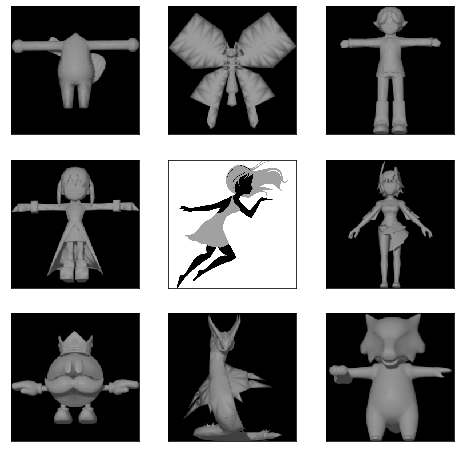

In [35]:
#Utility functions to un-normalize and display an image
def imshow(img):
    # img = img / 2 + 0.5          # don't need this line
    plt.imshow(np.transpose(img, (1, 2, 0))) 

#Obtain one batch of training images
dataiter = iter(train_loader)
images = dataiter.next()
images = np.array(images['image']) # convert images to numpy for display
print(torch.min(torch.tensor(images)), torch.max(torch.tensor(images)))
#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [ ]:
# #Define the Convolutional Autoencoder
# class ConvAutoencoder(nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()
       
#         #Encoder
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
#         self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
       
#         #Decoder
#         self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
#         self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.pool(x)
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         x = F.relu(self.t_conv1(x))
#         x = F.sigmoid(self.t_conv2(x))
              
#         return x


# #Instantiate the model
# model = ConvAutoencoder()
# print(model)

https://github.com/python-engineer/pytorch-examples/blob/master/Autoencoder.ipynb

In [36]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 4, 128, 128
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 16, 3, stride=2, padding=1), # -> N, 16, 64, 64
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 32, 32
            nn.ReLU(),
            nn.Conv2d(32, 64, 32) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 32), # -> N, 32, 32, 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, 3, stride=2, padding=1, output_padding=1), # N, 4, 28, 28  (N,4,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

#Instantiate the model
model = Autoencoder()
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(32, 32), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(32, 32), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


In [37]:
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cpu


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(32, 32), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(32, 32), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [ ]:
# #Epochs
# n_epochs = 100
# loss_values = []

# for epoch in range(1, n_epochs+1):
#     # monitor training loss
#     train_loss = 0.0

#     # Training
#     for data in train_loader:
#         images = data['image']/255
#         images = images.to(device)
#         optimizer.zero_grad()
#         # divide by 255 to convert tensor type float to type byte
#         outputs = model(images/255)
#         loss = criterion(outputs, images)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()*images.size(0)
          
#     train_loss = train_loss/len(train_loader)
#     loss_values.append(train_loss)
#     print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

# plt.plot(loss_values)

https://discuss.pytorch.org/t/plotting-loss-curve/42632/3

In [ ]:
# REFERENCE FOR GRAPHING
# for epoch in range(n_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         running_loss =+ loss.item() * images.size(0)

#     loss_values.append(running_loss / len(train_dataset))

# plt.plot(loss_values)

In [ ]:
# Point to training loop video
num_epochs = 50
outputs = []
loss_values = []

for epoch in range(num_epochs):
    # monitor training loss
    train_loss = 0.0

    # Training
    for img in train_loader:
      recon = model(img['image']/255)
      loss = criterion(recon, img['image']/255)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # print(type(loss.item()))
      # print(type(images.size(0)))
      train_loss += loss.item()*img['image'].size(0)

    train_loss = train_loss/len(train_loader)
    loss_values.append(train_loss)
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

plt.plot(loss_values)

2817
2817
Epoch:1, Loss:0.1728
2817
2817
Epoch:2, Loss:0.1572
2817
2817
Epoch:3, Loss:0.1426
2817
2817
Epoch:4, Loss:0.1254
2817
2817
Epoch:5, Loss:0.1208
2817
2817
Epoch:6, Loss:0.1141
2817
2817
Epoch:7, Loss:0.1115
2817
2817
Epoch:8, Loss:0.1107
2817
2817
Epoch:9, Loss:0.1073
2817
2817
Epoch:10, Loss:0.1061
2817
2817
Epoch:11, Loss:0.1053
2817
2817
Epoch:12, Loss:0.1049
2817
2817
Epoch:13, Loss:0.1053
2817
2817
Epoch:14, Loss:0.1046
2817
2817
Epoch:15, Loss:0.1048
2817
2817
Epoch:16, Loss:0.1046
2817
2817
Epoch:17, Loss:0.1064
2817
2817
Epoch:18, Loss:0.1051
2817
2817
Epoch:19, Loss:0.1050
2817
2817
Epoch:20, Loss:0.1057
2817
2817
Epoch:21, Loss:0.1084
2817
2817
Epoch:22, Loss:0.1053
2817
2817
Epoch:23, Loss:0.1038
2817


In [ ]:
for k in range(0, num_epochs, 1):
    imgs = outputs[k][1]['image'].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(recon):
        if i >= 1: break
        # item: 4, 128, 128
        print(item)

In [ ]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = (outputs1[k][1]['image']/255).cpu().detach().numpy()
    recon = outputs1[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item: 1, 28, 28
        plt.imshow(item[0])

In [ ]:
#Batch of test images
dataiter = iter(test_loader)
images = dataiter.next()

#Sample outputs
images = images['image'].to(device)
output = model(images/255)
images = images.cpu().numpy()

batch_size=32
output = output.view(batch_size, 4, 128, 128)
output = output.detach().numpy()
#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
plt.show() 